# N.Onur VURAL 21902330 SECTION 2

**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

The main point of softmax gives probabilities that sums up to one. Accordingly the output numbers are probability distrubutions that are meaningful within themselves. The largest value indicates highest likelihhod of class. As they should sum upto 1, values may range between 0-1 <br>

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

A neural network model that underfits is much simple (few preceptors), has high bias wheras one that overfits is composed of complex layers and more weights, has a high varience. To understand such behaviours, plotting errors of train and test sets can be informative. Overfitting will show very low train error but will begin to have increasing test errors. In an underfitting situation, the train error will be large together with test error. The best complexity selection will aim having a good train and test error result where their difference will be low as well. <br>

c) In neural networks, how does the ReLU function help us to generalize to conplex feature spaces? Why we are not using linear layers only? <br>

ReLU helps to generalize complex feature space by eliminating nonzero inputs and at the same time preventing the risk of vansihing gradients. It ends up with a rectified feature map that looking the features coming through. The whole point of using activation function is being non-linear. When we use linear activation functions, they are essentially linear combinations where it essentially reduces to being one layer. In ReLU, the linear combination with other layers does not fall into this problem, being more complex. <br>

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

#no learnable params = inputs * outputs + biases
input = 5 <br>
output = 3 x 3 x 6 = 54 <br>
bias = 6 <br>
learnable param no = 276 <br>
64x64x5 * 6 of 3x3x5 <br>
= 62x62x6 <br>

<br>

# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [1]:
import os 
import time
import random

import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [2]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [3]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

In [4]:
from google.colab import drive

# Mounting Google Drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        return self.data[index].reshape(224,224,3)/255, self.labels[index]
        #return self.data[index], self.labels[index]

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [6]:
dataset_dir = '/content/gdrive/MyDrive/Multi-class Weather Dataset'

Categories = ['Cloudy', 'Rain', 'Shine', 'Sunrise'] # Cloudy = 0, Rain = 1, Shine = 2, Sunrise = 3
Categories_Dict = { 'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise':3 }
data_cloudy = torchvision.datasets.ImageFolder(dataset_dir)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()])

img_array = np.zeros((1125, 224*224, 3))
label_array = np.zeros(1125)
i = 0

for category in Categories:
  path = os.path.join(dataset_dir, category)
  for image in os.listdir(path):
    im = PIL.Image.open( path + '/' + image).convert("RGB").resize((224,224), Image.BILINEAR)
    im = np.array(im)
    #print(im.shape)
    #print(image)
    d1, d2, d3 = im.shape
    im = im.flatten().reshape(d1*d2, d3)
    img_array[i] = im
    label_array[i] = Categories_Dict[category]
    i = i + 1

print(label_array.shape)
print(img_array.shape)
print(label_array)
print(img_array[0].shape)


# Dataset getter method
def prepareSamples(img_array, label_array, train_ratio, val_ratio, test_ratio):

    # shuffle process
    indices = np.arange(label_array.shape[0])
    np.random.shuffle(indices)
    label_array = label_array[indices]
    img_array = img_array[indices]

    number_of_instances = len(img_array)
    train_size = int(number_of_instances * train_ratio)
    val_size = int(number_of_instances * val_ratio)
    test_size = int(number_of_instances * test_ratio)
    
    train_x = img_array[:train_size]
    train_y = label_array[:train_size]
    
    val_x = img_array[train_size: train_size + val_size]
    val_y = label_array[train_size: train_size + val_size]
    
    test_x = img_array[train_size + val_size:]
    test_y = label_array[train_size + val_size:]

    # Loading dataset
    train_dataset = CustomDataset(train_x, train_y)  
    val_dataset = CustomDataset(val_x, val_y) 
    test_dataset = CustomDataset(test_x, test_y) 
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepareSamples(img_array, label_array, 0.7, 0.1, 0.2)
print(train_dataset.__len__())

(1125,)
(1125, 50176, 3)
[0. 0. 0. ... 3. 3. 3.]
(50176, 3)
787


## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [7]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, conv_channels):
        super(ConvNet, self).__init__()

        assert len(conv_channels) == 3 # I will have 3 consecutive convultional blocks
        self.conv_channels = conv_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=self.conv_channels[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.conv_channels[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d( in_channels=self.conv_channels[0], out_channels=self.conv_channels[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.conv_channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d( in_channels=self.conv_channels[1], out_channels=self.conv_channels[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.conv_channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        output_size = (224 // 8) # Downsampled it 3 times
        self.fc_1 = nn.Linear(in_features=self.conv_channels[2] * output_size * output_size, out_features = 10)

    def forward(self, x): 
        output_size = (224 // 8) # Downsampled it 3 times
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Flattening matrix # x = x.view(x.size(0), -1)
        x = x.view(-1, self.conv_channels[2] * output_size * output_size)
        x = self.fc_1(x)
        return x
        

### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [ ]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, conv_channels ):
        super(FCNet, self).__init__()

        assert len(conv_channels) == 3 # I will have 3 consecutive convultional blocks
        self.conv_channels = conv_channels
        input_ft_size = 3*224*224  # We have 3 channel 224x224 matrix entering
        output_size = 10 # We have 10 diff classes

        self.fc1 = nn.Linear( in_features=input_ft_size, out_features=self.conv_channels[0])
        self.fc2 = nn.Linear( in_features=self.conv_channels[0], out_features=self.conv_channels[1])
        self.fc3 = nn.Linear( in_features=self.conv_channels[1], out_features=self.conv_channels[2])
        self.classification_layer = nn.Linear( in_features=self.conv_channels[2], out_features=output_size)
        #self.logSoftmax = LogSoftmax(dim=1)
     
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)

        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)
        x = torch.relu(x)

        # The output layer
        x = self.classification_layer(x)
        # x = x.to(torch.float32)
        # print(x.dtype())
        #output = self.logSoftmax(x)
        return x


## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

In [ ]:
is_gpu_available = torch.cuda.is_available()

# prepare the model
criterion = nn.CrossEntropyLoss()
conv_channels = [1024, 512, 256]
model = FCNet(conv_channels)
if is_gpu_available:
    model.cuda()



(224, 224, 3)
2.0


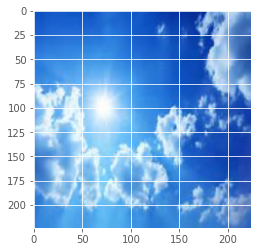

In [ ]:
import matplotlib.pyplot as plt
item_x, item_label = train_dataset.__getitem__(5)
print(item_x.shape)
print(item_label)
plt.imshow((item_x * 255).astype("uint8"))


### Training [12 points]

#EX1: LEARNING RATE EXPERIMENTS

For learning rate=  0.5
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Val loss for epoch: 0.21722611097189096
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Val loss for epoch: 0.19024052986731896
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.19032238996945894
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.14939161905875573
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Val loss for epoch: 0.13252325241382307
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.2405481796998244
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.13853325293614313
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.1304817428955665
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.18265546285189116
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


Val loss for epoch: 0.11816052748606755
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.10753884223791269
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


Val loss for epoch: 0.13005063625482413
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.1006006277524508
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.1548060683103708
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


Val loss for epoch: 0.16101455229979295
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Val loss for epoch: 0.12357974052429199
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.1108522369311406
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.09654864439597496
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Val loss for epoch: 0.12265522663409893
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.1121404767036438
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.08921465965417716
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.09955698251724243
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.12249532571205726
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.11071812189542331
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


Val loss for epoch: 0.0856892283146198
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.10441466019703792
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.07047960849908683
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.07090869775185218
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.2837340556658231
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


Val loss for epoch: 0.16393165404979998
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.23654507673703706
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.13572141298880944
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.12858935044361994
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.5172699047968938
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Val loss for epoch: 0.17190716816828802
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.12189233761567336
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.1419773010107187
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.14021431941252488
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.16387356703098005
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.14056147978856012
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.1162461730150076
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.12412184476852417
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Val loss for epoch: 0.18026818678929254
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.10733799292491032
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.19893948848430926
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Val loss for epoch: 0.12411533869229831
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.10799800891142625
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.13305346323893621
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.09825501992152287
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.14106082457762498
For learning rate=  0.05
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.12505082900707537
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.09572091010900644
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.180997921870305
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.1604273135845478
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.12874542749845064
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.0984454659315256
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.10062467593413132
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.12546458611121544
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Val loss for epoch: 0.08985442152390113
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.0962045146868779
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.09582762993299045
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.09703446810062115
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.11715636345056388
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.10415531121767484
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.09366343571589543
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.10122196032450749
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.0893061481989347
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.12222380363024198
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.18100553292494553
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.09268685029103206
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.11284109033071078
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.13200030877039984
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.09932847664906429
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.28891392854543835
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.09224250683417687
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.10139650794175956
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.08343859360768245
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.10330077318044809
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Val loss for epoch: 0.1366731753716102
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.08758203112162076
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.10363061840717609
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.10083387448237492
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.09641132446435782
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.08576043294026302
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.08689072269659776
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.0954028505545396
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.1067782869705787
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.1179440113214346
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.0812647663629972
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.084847459426293
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.0843210953932542
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.08669109986378597
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


Val loss for epoch: 0.08325906900259164
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.07636791009169358
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Val loss for epoch: 0.07657167773980361
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Val loss for epoch: 0.11871612988985501
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Val loss for epoch: 0.09541717859414908
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.085711080294389
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


Val loss for epoch: 0.08398389357786912
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.08148679595727187
For learning rate=  0.005
Epoch: 1/50


100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


Val loss for epoch: 0.12988044665409967
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Val loss for epoch: 0.09305471181869507
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08501929503220779
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.11207819901979886
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Val loss for epoch: 0.09264704814324012
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.0825083485016456
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.08282240995993981
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.07942301034927368
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.11780402752069327
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.13466985867573664
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Val loss for epoch: 0.07006064974344693
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08196479999102078
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.08664083022337693
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.10709517506452707
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08345394868117112
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.07896709442138672
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.06857064366340637
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


Val loss for epoch: 0.07306997592632587
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.10833692779907814
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.09910789819864127
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.10072413316139808
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.0790113967198592
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.07960509336911716
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.0778113603591919
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.19514532272632307
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.06705195170182449
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.0925628451200632
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.0726916973407452
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Val loss for epoch: 0.06454271307358375
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.11947018595842215
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.10042598385077256
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.08755750381029569
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.0795428454875946
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.1301969702427204
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Val loss for epoch: 0.08609429918802701
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.06463631299825814
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.06367078194251427
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.06161538454202505
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Val loss for epoch: 0.12520936819223258
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.18149366745581993
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Val loss for epoch: 0.09932516629879291
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Val loss for epoch: 0.1352322560090285
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.08777817625265855
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.0785059447471912
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.1296795652462886
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Val loss for epoch: 0.08562072882285485
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Val loss for epoch: 0.13500008674768302
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Val loss for epoch: 0.08025891735003544
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.08286477969242977
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.09565076461205116
For learning rate=  0.0005
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.08651728813464825
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.09838656278756949
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.14128308571301973
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08392884181096004
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Val loss for epoch: 0.08285971788259652
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.0547806414274069
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Val loss for epoch: 0.19936654200920692
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  7.97it/s]


Val loss for epoch: 0.1052224590228154
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.13668124950849092
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Val loss for epoch: 0.06408442212985112
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Val loss for epoch: 0.094984403023353
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Val loss for epoch: 0.09269377818474403
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.2168887028327355
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Val loss for epoch: 0.07584131681002103
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.08622610110502976
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


Val loss for epoch: 0.07162714692262503
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


Val loss for epoch: 0.18592343880580023
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.0903779543363131
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Val loss for epoch: 0.06723498610349801
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Val loss for epoch: 0.11324179631013137
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.10437076366864718
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.06578016510376564
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.06042724389296312
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.10948031223737277
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.0820796535565303
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.06715553998947144
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.05904198839114262
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08975472817054161
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.10898550657125619
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.098007293847891
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.11866425092403705
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.11531186562318069
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.08251538872718811
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.18049845328697792
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.10734741962873019
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.11068179057194637
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.09271853932967553
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.09385107113764836
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.08811878470274118
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.1228420092509343
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.07560550020291255
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


Val loss for epoch: 0.09068128695854774
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.07360271765635563
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.12618989669359648
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.10891594336583064
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.18941028760029718
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.19316045137552115
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.08035790920257568
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.10157817143660325
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.08896886385404147
For learning rate=  5e-05
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.08508588717533992
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.10280055724657498
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.16201889973420364
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.16875764956841102
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.09237009286880493
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.0889532336821923
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.12306012098605816
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.11036144540860103
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.15608702714626604
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.07622880202073318
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.11280368383114155
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.10296885783855732
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.08654226706578182
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.07629640285785382
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.08814501533141503
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.07859122982391945
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.1030489573111901
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.0726459393134484
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.10799151659011841
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Val loss for epoch: 0.17973896173330453
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.09035310378441444
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.13425021446668184
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


Val loss for epoch: 0.08378626520817097
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.08154181104439956
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.08103780563061054
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.08499680574123676
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.13498279681572548
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.09395851080234234
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.07056010686434232
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.08122998246779808
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.07671034565338722
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.16832232475280762
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.09542426008444566
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.07346177101135254
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.07166957167478707
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.08570552101502052
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.34001391667586106
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.13778300468738264
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.09538196371151851
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.08148683951451229
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.10409782024530265
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.08541826559947087
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.07776591181755066
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.14240408860720122
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.12070180361087506
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.09382647046676049
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


Val loss for epoch: 0.10239035349625808
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.08484428891768822
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.30994534492492676
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.07786828050246605


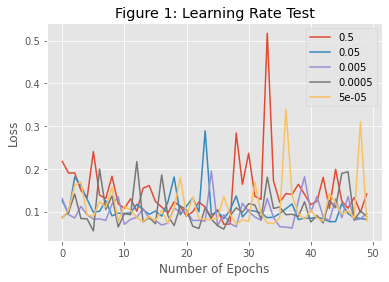

In [ ]:
# TODO: training loop + eval
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt

learning_rates = [5e-1, 5e-2, 5e-3, 5e-4, 5e-5]
accuracies_lr = [0, 0, 0, 0, 0]
for ler in learning_rates: 
  # Required components
  print("For learning rate= ", ler)
  train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
  val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
  optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.5, weight_decay = 5e-04) #params are selected by experiments

  # Training loop
  train_losses = []
  val_losses = []  
  no_of_epochs = 50
  iter_losses = []

  for epoch in range(no_of_epochs):
    train_running_loss = 0.0
    
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0
        batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda()) # Predict outputs
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
    train_losses.append(train_running_loss / len(train_data_loader))
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor) 
          batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda())
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_losses.append(val_epoch_loss)
  plt.plot(range(len(val_losses)), val_losses, label = ler)
  
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Figure 1: Learning Rate Test')
plt.legend()
plt.show()

#EX2: EPOCH SIZE

Epoch: 1/100


100%|██████████| 13/13 [00:01<00:00,  7.62it/s]


Loss for epoch: 0.2423795358492778
Epoch: 2/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.26292455425629246
Epoch: 3/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.2729277794177716
Epoch: 4/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Loss for epoch: 0.3207098280008023
Epoch: 5/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Loss for epoch: 0.22512559019602263
Epoch: 6/100


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Loss for epoch: 0.21004106448246881
Epoch: 7/100


100%|██████████| 13/13 [00:01<00:00,  7.97it/s]


Loss for epoch: 0.17927862187990776
Epoch: 8/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.17373225952570254
Epoch: 9/100


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Loss for epoch: 0.2951869855706508
Epoch: 10/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Loss for epoch: 0.25429161809957945
Epoch: 11/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.25043477232639605
Epoch: 12/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.20990478705901366
Epoch: 13/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.23850077505295092
Epoch: 14/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.23073063103052285
Epoch: 15/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.37429387867450714
Epoch: 16/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.28929070039437366
Epoch: 17/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.16504533875447053
Epoch: 18/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loss for epoch: 0.15066210753642595
Epoch: 19/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.6707652876010308
Epoch: 20/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Loss for epoch: 0.31416510389401364
Epoch: 21/100


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Loss for epoch: 0.3641133113549306
Epoch: 22/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.5656264619185374
Epoch: 23/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Loss for epoch: 0.7889292010894189
Epoch: 24/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.4564284361325778
Epoch: 25/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Loss for epoch: 0.26228793538533723
Epoch: 26/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.31814584078697056
Epoch: 27/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Loss for epoch: 0.1405940720668206
Epoch: 28/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Loss for epoch: 0.33629969507455826
Epoch: 29/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.5194740272485293
Epoch: 30/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Loss for epoch: 0.24633672260321104
Epoch: 31/100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Loss for epoch: 0.2124759084903277
Epoch: 32/100


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Loss for epoch: 0.35023268254903644
Epoch: 33/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.27746955248025745
Epoch: 34/100


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Loss for epoch: 0.3004935154548058
Epoch: 35/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Loss for epoch: 0.1826393546966406
Epoch: 36/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Loss for epoch: 0.21477122633503035
Epoch: 37/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.34208721724840313
Epoch: 38/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.2766453463297624
Epoch: 39/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Loss for epoch: 0.19277275582918754
Epoch: 40/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Loss for epoch: 0.28983806990660155
Epoch: 41/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.3544920797531421
Epoch: 42/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loss for epoch: 0.14791568655234116
Epoch: 43/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Loss for epoch: 0.15980204424032798
Epoch: 44/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loss for epoch: 0.1441024742447413
Epoch: 45/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.2044519197482329
Epoch: 46/100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Loss for epoch: 0.1665877470603356
Epoch: 47/100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Loss for epoch: 0.2286790764102569
Epoch: 48/100


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Loss for epoch: 0.1865311683370517
Epoch: 49/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 1.3733565956354141
Epoch: 50/100


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Loss for epoch: 0.8921444049248328
Epoch: 51/100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Loss for epoch: 0.8169094622135162
Epoch: 52/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.7892534274321336
Epoch: 53/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.7158292761215796
Epoch: 54/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.7223768921998831
Epoch: 55/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.675894177876986
Epoch: 56/100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Loss for epoch: 0.6314893640004672
Epoch: 57/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.7255024772423965
Epoch: 58/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.6395812814052289
Epoch: 59/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loss for epoch: 0.606662624157392
Epoch: 60/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Loss for epoch: 0.5952034317530118
Epoch: 61/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Loss for epoch: 0.5426410344930795
Epoch: 62/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Loss for epoch: 0.5981827080249786
Epoch: 63/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.5751087550933545
Epoch: 64/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.8814472968761737
Epoch: 65/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Loss for epoch: 0.7653311995359567
Epoch: 66/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loss for epoch: 0.6784212589263916
Epoch: 67/100


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Loss for epoch: 0.7187643142846915
Epoch: 68/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Loss for epoch: 0.7779604517496549
Epoch: 69/100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Loss for epoch: 0.7248613421733563
Epoch: 70/100


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Loss for epoch: 0.7067617109188666
Epoch: 71/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Loss for epoch: 0.6993650610630329
Epoch: 72/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Loss for epoch: 0.7303029390481802
Epoch: 73/100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Loss for epoch: 0.7339336000956022
Epoch: 74/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.7173589101204505
Epoch: 75/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Loss for epoch: 0.7100865565813504
Epoch: 76/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Loss for epoch: 0.6137446096310248
Epoch: 77/100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Loss for epoch: 0.615261394243974
Epoch: 78/100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Loss for epoch: 0.5777343557431147
Epoch: 79/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Loss for epoch: 0.5256905670349414
Epoch: 80/100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Loss for epoch: 1.29829930800658
Epoch: 81/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Loss for epoch: 0.7190086199687078
Epoch: 82/100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Loss for epoch: 0.7020341983208289
Epoch: 83/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Loss for epoch: 0.6754687015826886
Epoch: 84/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.647354435462218
Epoch: 85/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.6993230535433843
Epoch: 86/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Loss for epoch: 0.5668935706982245
Epoch: 87/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Loss for epoch: 0.6582362743524405
Epoch: 88/100


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Loss for epoch: 0.5606847451283381
Epoch: 89/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Loss for epoch: 0.6124073840104617
Epoch: 90/100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Loss for epoch: 0.9822399983039269
Epoch: 91/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Loss for epoch: 0.8293632039657006
Epoch: 92/100


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Loss for epoch: 0.7648629592015193
Epoch: 93/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Loss for epoch: 0.7440673067019536
Epoch: 94/100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Loss for epoch: 0.8038797149291406
Epoch: 95/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Loss for epoch: 0.7438032214458172
Epoch: 96/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.7468127791698163
Epoch: 97/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.7007182469734778
Epoch: 98/100


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Loss for epoch: 0.6729587591611422
Epoch: 99/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loss for epoch: 0.7636052186672504
Epoch: 100/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Loss for epoch: 0.7008269131183624


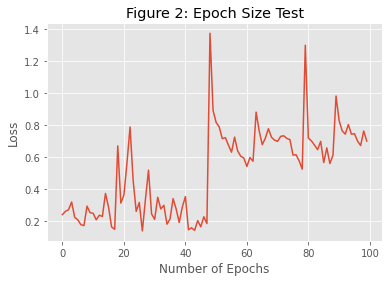

The best loss value is  0.1405940720668206  achieved by  27


In [ ]:
learning_rate = 5e-2 # We pick the best - most stable learning rate from experiment results
no_of_epochs = 100
minYieldingEpoch = -1 
minloss = 1

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5, weight_decay = 5e-04)
# Training loop
iter_losses = []
epoch_losses = []
for epoch in range(no_of_epochs):
  running_loss = 0.0
  print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
  for batch_data, batch_labels in tqdm(train_data_loader):
      batch_labels = batch_labels.type(torch.LongTensor) 
      optimizer.zero_grad() # Setting the starting gradients as 0
      batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda()) # Predict outputs
      loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) # Calculate the loss
      loss.backward() # Calculate the gradients
      optimizer.step() # Update the weights
      iter_losses.append(loss.item())
      running_loss += loss.item()
 
  if running_loss / len(train_data_loader) <= minloss:
    minYieldingEpoch = epoch + 1
    minloss = running_loss / len(train_data_loader)
  epoch_losses.append(running_loss / len(train_data_loader))
  print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))

plt.plot(range(len(epoch_losses)), epoch_losses, label = learning_rate)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Figure 2: Epoch Size Test')
plt.show()

print("The best loss value is ", minloss, " achieved by ", minYieldingEpoch)

#EX3: BATCH SIZE

For batch size=  64
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.11728527912726769
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.11357867259245652
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.1379313010435838
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.11998869822575496
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.11962375274071327
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Val loss for epoch: 0.11087654187129094
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.34058523178100586
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.11898022431593674
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.11871869288958035
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.11853829713968131
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.12234245355312641
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.1191520278270428
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


Val loss for epoch: 0.11525217844889714
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.11328578453797561
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.11363946016018207
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.11188368613903339
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.10885960322159988
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.11162691849928635
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.10986384520163903
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.11105493857310368
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.12207096356611985
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.10692236515191886
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.11017770950610821
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.10900377310239352
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.12254887360792893
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.08818548459273118
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.12786041773282564
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.10038114052552444
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.08035633655694815
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.12641274012052095
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.1208662069760836
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


Val loss for epoch: 0.1093060878606943
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.10198385898883526
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


Val loss for epoch: 0.26105719346266526
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.13302578834386972
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.1184127926826477
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.11911505002241868
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.12509655952453613
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


Val loss for epoch: 0.10586048089540921
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.1033097688968365
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.1137723785180312
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.11043605437645546
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.11142251124748817
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.0950818657875061
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.1791107287773719
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.12269986134309036
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.0940902095574599
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.15918794045081505
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.12729989565335786
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.12759956946739784
For batch size=  150
Epoch: 1/50


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Val loss for epoch: 0.15581648548444113
Epoch: 2/50


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Val loss for epoch: 0.13608595728874207
Epoch: 3/50


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Val loss for epoch: 0.1359195113182068
Epoch: 4/50


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Val loss for epoch: 0.14618825912475586
Epoch: 5/50


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


Val loss for epoch: 0.16631683707237244
Epoch: 6/50


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Val loss for epoch: 0.13668686151504517
Epoch: 7/50


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Val loss for epoch: 0.1437135636806488
Epoch: 8/50


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Val loss for epoch: 0.14913134773572287
Epoch: 9/50


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Val loss for epoch: 0.18048020203908285
Epoch: 10/50


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


Val loss for epoch: 0.13970127701759338
Epoch: 11/50


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Val loss for epoch: 0.15709790587425232
Epoch: 12/50


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Val loss for epoch: 0.1373972793420156
Epoch: 13/50


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Val loss for epoch: 0.14841178059577942
Epoch: 14/50


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Val loss for epoch: 0.12532283862431845
Epoch: 15/50


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


Val loss for epoch: 0.14134926597277322
Epoch: 16/50


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Val loss for epoch: 0.11914061506589253
Epoch: 17/50


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Val loss for epoch: 0.1443343460559845
Epoch: 18/50


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Val loss for epoch: 0.12856758634249368
Epoch: 19/50


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Val loss for epoch: 0.11780007680257161
Epoch: 20/50


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Val loss for epoch: 0.11649313569068909
Epoch: 21/50


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Val loss for epoch: 0.12324520945549011
Epoch: 22/50


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Val loss for epoch: 0.11530059576034546
Epoch: 23/50


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Val loss for epoch: 0.11342859268188477
Epoch: 24/50


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


Val loss for epoch: 0.12557641665140787
Epoch: 25/50


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Val loss for epoch: 0.13525035977363586
Epoch: 26/50


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Val loss for epoch: 0.17562556266784668
Epoch: 27/50


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Val loss for epoch: 0.13851921757062277
Epoch: 28/50


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


Val loss for epoch: 0.1443290114402771
Epoch: 29/50


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Val loss for epoch: 0.17028391361236572
Epoch: 30/50


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


Val loss for epoch: 0.139731099208196
Epoch: 31/50


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Val loss for epoch: 0.14090882738431296
Epoch: 32/50


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Val loss for epoch: 0.13167747855186462
Epoch: 33/50


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


Val loss for epoch: 0.12181057532628377
Epoch: 34/50


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Val loss for epoch: 0.11756054560343425
Epoch: 35/50


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


Val loss for epoch: 0.1229655643304189
Epoch: 36/50


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Val loss for epoch: 0.11685427029927571
Epoch: 37/50


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Val loss for epoch: 0.11873951554298401
Epoch: 38/50


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Val loss for epoch: 0.12634660800298056
Epoch: 39/50


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Val loss for epoch: 0.1362848381201426
Epoch: 40/50


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Val loss for epoch: 0.12600286801656088
Epoch: 41/50


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Val loss for epoch: 0.11670584479967754
Epoch: 42/50


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


Val loss for epoch: 0.12319174408912659
Epoch: 43/50


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


Val loss for epoch: 0.12119939923286438
Epoch: 44/50


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


Val loss for epoch: 0.12444310386975606
Epoch: 45/50


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Val loss for epoch: 0.1142463485399882
Epoch: 46/50


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


Val loss for epoch: 0.11166366934776306
Epoch: 47/50


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


Val loss for epoch: 0.1188020904858907
Epoch: 48/50


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


Val loss for epoch: 0.12427091598510742
Epoch: 49/50


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


Val loss for epoch: 0.14615802963574728
Epoch: 50/50


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


Val loss for epoch: 0.12605788310368857
For batch size=  300
Epoch: 1/50


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Val loss for epoch: 0.25728557507197064
Epoch: 2/50


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Val loss for epoch: 0.2530364990234375
Epoch: 3/50


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Val loss for epoch: 0.22768948475519815
Epoch: 4/50


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Val loss for epoch: 0.22059045235315958
Epoch: 5/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.2235464851061503
Epoch: 6/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.2415276567141215
Epoch: 7/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.23180033763249716
Epoch: 8/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.2730328440666199
Epoch: 9/50


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Val loss for epoch: 0.2545844117800395
Epoch: 10/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.2331980069478353
Epoch: 11/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.2508416771888733
Epoch: 12/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.27310214440027875
Epoch: 13/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.24951080481211343
Epoch: 14/50


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Val loss for epoch: 0.23240596055984497
Epoch: 15/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.25101006031036377
Epoch: 16/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.23388961950937906
Epoch: 17/50


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Val loss for epoch: 0.24088491996129355
Epoch: 18/50


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Val loss for epoch: 0.24137369791666666
Epoch: 19/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.2452727953592936
Epoch: 20/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.23243141174316406
Epoch: 21/50


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Val loss for epoch: 0.276753048102061
Epoch: 22/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.23453330993652344
Epoch: 23/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.22677751382191977
Epoch: 24/50


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Val loss for epoch: 0.2270105481147766
Epoch: 25/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.23489540815353394
Epoch: 26/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.2700815002123515
Epoch: 27/50


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Val loss for epoch: 0.28890736897786456
Epoch: 28/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.23774848381678262
Epoch: 29/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.23113842805226645
Epoch: 30/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.23184837897618613
Epoch: 31/50


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Val loss for epoch: 0.2337099313735962
Epoch: 32/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.2359567085901896
Epoch: 33/50


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Val loss for epoch: 0.23427114884058634
Epoch: 34/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.23739385604858398
Epoch: 35/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.2381520668665568
Epoch: 36/50


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Val loss for epoch: 0.24428141117095947
Epoch: 37/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.23948816458384195
Epoch: 38/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.23801352580388388
Epoch: 39/50


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Val loss for epoch: 0.24033828576405844
Epoch: 40/50


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Val loss for epoch: 0.32117950916290283
Epoch: 41/50


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Val loss for epoch: 0.27019602060317993
Epoch: 42/50


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Val loss for epoch: 0.2704291542371114
Epoch: 43/50


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Val loss for epoch: 0.26582223176956177
Epoch: 44/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.26982514063517254
Epoch: 45/50


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Val loss for epoch: 0.24508130550384521
Epoch: 46/50


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Val loss for epoch: 0.23486814896265665
Epoch: 47/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.24538028240203857
Epoch: 48/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.24033814668655396
Epoch: 49/50


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Val loss for epoch: 0.24658125638961792
Epoch: 50/50


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Val loss for epoch: 0.23267634709676108
For batch size=  787
Epoch: 1/50


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


Val loss for epoch: 0.7773566246032715
Epoch: 2/50


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Val loss for epoch: 0.7309912443161011
Epoch: 3/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7099997401237488
Epoch: 4/50


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Val loss for epoch: 0.723456084728241
Epoch: 5/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.6917052268981934
Epoch: 6/50


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Val loss for epoch: 0.6859439015388489
Epoch: 7/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.7165762782096863
Epoch: 8/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Val loss for epoch: 0.6860604882240295
Epoch: 9/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.6942996382713318
Epoch: 10/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Val loss for epoch: 0.6973698735237122
Epoch: 11/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Val loss for epoch: 0.7000072598457336
Epoch: 12/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7058576941490173
Epoch: 13/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.7044889330863953
Epoch: 14/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7058704495429993
Epoch: 15/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.7106526494026184
Epoch: 16/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.717708945274353
Epoch: 17/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7119835615158081
Epoch: 18/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7174280285835266
Epoch: 19/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7393055558204651
Epoch: 20/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.7282066345214844
Epoch: 21/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7545595765113831
Epoch: 22/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.7279991507530212
Epoch: 23/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.6999179720878601
Epoch: 24/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.7000289559364319
Epoch: 25/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Val loss for epoch: 0.7023898959159851
Epoch: 26/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.7007060050964355
Epoch: 27/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.6986699104309082
Epoch: 28/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.704086422920227
Epoch: 29/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.6877732872962952
Epoch: 30/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.678760826587677
Epoch: 31/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.6622583270072937
Epoch: 32/50


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Val loss for epoch: 0.6404908299446106
Epoch: 33/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.6284774541854858
Epoch: 34/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.6341094374656677
Epoch: 35/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.6243391633033752
Epoch: 36/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.6268388032913208
Epoch: 37/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.6133366227149963
Epoch: 38/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.6232972145080566
Epoch: 39/50


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Val loss for epoch: 0.6217012405395508
Epoch: 40/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.5996784567832947
Epoch: 41/50


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Val loss for epoch: 0.6129698753356934
Epoch: 42/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.6080255508422852
Epoch: 43/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.5984373092651367
Epoch: 44/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.6056361198425293
Epoch: 45/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.5979857444763184
Epoch: 46/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.5963555574417114
Epoch: 47/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.5952186584472656
Epoch: 48/50


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Val loss for epoch: 0.5854821801185608
Epoch: 49/50


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Val loss for epoch: 0.5962440371513367
Epoch: 50/50


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Val loss for epoch: 0.5913659334182739


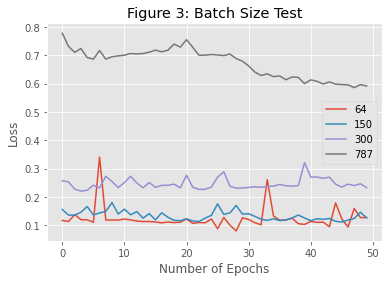

In [ ]:
batch_sizes = [64, 150, 300, train_dataset.__len__() ]
from tqdm import tqdm
for batch in batch_sizes: 
  # Required components
  print("For batch size= ", batch)
  train_data_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True) 
  val_data_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
  optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.5, weight_decay = 5e-04) #params are selected by experiments

  # Training loop
  train_losses = []
  val_losses = []  
  no_of_epochs = 50
  iter_losses = []

  for epoch in range(no_of_epochs):
    train_running_loss = 0.0
    
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0
        batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda()) # Predict outputs
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
    train_losses.append(train_running_loss / len(train_data_loader))
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor) 
          batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda())
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_losses.append(val_epoch_loss)
  plt.plot(range(len(val_losses)), val_losses, label = batch)
  
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Figure 3: Batch Size Test')
plt.legend()
plt.show()








In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
class SaveBestModelFCNet:
    
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'sample_data/bestModelFCNet.pth')
            
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'sample_data/final_model.pth')
              

# TRAINING BEST MODEL

In [ ]:
# Required components
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.5, weight_decay = 5e-04) #params are selected by experiments
save_best_model_FCNet = SaveBestModelFCNet()

from tqdm import tqdm
# Training loop
train_accuracies = []
train_losses = []

val_losses = []
val_accuracies = []

no_of_epochs = 100
iter_losses = []


for epoch in range(no_of_epochs):
    #model.train()
    train_running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0
        batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda()) # Predict outputs
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
        # Calculate the accuracy
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        #pred_labels = pred_labels.to("cuda")
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
        all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
        all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)
    train_losses.append(train_running_loss / len(train_data_loader))
    train_accuracies.append(correct_preds / total_preds)

    model.eval()
    val_running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor) 
          batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda())
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
          # Calculate the accuracy
          # Max returns: (max_values, max_indices)
          # We only need the indices to assess the predictions
          _, pred_labels = torch.max(batch_outputs, dim=1)
          total_preds += pred_labels.size(0)
          correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
          all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
          all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)
      #print("Accuracy: {}".format(correct_preds / total_preds))
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(correct_preds / total_preds)

    #Save best model
    save_best_model_FCNet(
        val_epoch_loss, epoch, model, optimizer, criterion
    )

# save the trained model weights for a final time
save_model(no_of_epochs, model, optimizer, criterion) 
print("Finished Training Best Model!")

Epoch: 1/100


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Val loss for epoch: 0.09729268000676082
Epoch: 2/100


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Val loss for epoch: 0.10120235039637639
Epoch: 3/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.13263757870747492
Epoch: 4/100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.10772511133780846
Epoch: 5/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.15682446498137254
Epoch: 6/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.11420974364647499
Epoch: 7/100


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.12009285505001362
Epoch: 8/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.11826193332672119
Epoch: 9/100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.10299976972433236
Epoch: 10/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.11607502515499409
Epoch: 11/100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.13267758259406456
Epoch: 12/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.09559225119077243
Epoch: 13/100


100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


Val loss for epoch: 0.09923119728381817
Epoch: 14/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.11037584910025963
Epoch: 15/100


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.09128058415192825
Epoch: 16/100


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Val loss for epoch: 0.09445612247173603
Epoch: 17/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.1362152649806096
Epoch: 18/100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.15043163758057815
Epoch: 19/100


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.09883879239742573
Epoch: 20/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.14143449526566726
Epoch: 21/100


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Val loss for epoch: 0.10087262667142428
Epoch: 22/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.10511958599090576
Epoch: 23/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.10508778920540443
Epoch: 24/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.13504405663563654
Epoch: 25/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.09567041121996366
Epoch: 26/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.13189257108248198
Epoch: 27/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.11581452534748958
Epoch: 28/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.09585350751876831
Epoch: 29/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.11509107626401462
Epoch: 30/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.09798224614216731
Epoch: 31/100


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


Val loss for epoch: 0.10200680677707379
Epoch: 32/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.4630414889408992
Epoch: 33/100


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Val loss for epoch: 0.09398538561967704
Epoch: 34/100


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


Val loss for epoch: 0.09834790229797363
Epoch: 35/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.12747815939096305
Epoch: 36/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.08636606427339408
Epoch: 37/100


100%|██████████| 13/13 [00:01<00:00,  8.32it/s]


Val loss for epoch: 0.08847813881360568
Epoch: 38/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.08878529988802396
Epoch: 39/100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.08642155619767997
Epoch: 40/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.08640652436476487
Epoch: 41/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.1622398174726046
Epoch: 42/100


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.08383036118287307
Epoch: 43/100


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Val loss for epoch: 0.0937693898494427
Epoch: 44/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.09979560742011437
Epoch: 45/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.1595445412855882
Epoch: 46/100


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.08196305999389061
Epoch: 47/100


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Val loss for epoch: 0.6722953136150653
Epoch: 48/100


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Val loss for epoch: 0.09731350036767814
Epoch: 49/100


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Val loss for epoch: 0.09342857507558969
Epoch: 50/100


100%|██████████| 13/13 [00:02<00:00,  4.78it/s]


Val loss for epoch: 0.11483164934011605
Epoch: 51/100


100%|██████████| 13/13 [00:01<00:00,  7.71it/s]


Val loss for epoch: 0.0974764136167673
Epoch: 52/100


100%|██████████| 13/13 [00:01<00:00,  7.75it/s]


Val loss for epoch: 0.10717270924494816
Epoch: 53/100


100%|██████████| 13/13 [00:01<00:00,  7.60it/s]


Val loss for epoch: 0.13579151722101065
Epoch: 54/100


100%|██████████| 13/13 [00:01<00:00,  7.54it/s]


Val loss for epoch: 0.14760308082287127
Epoch: 55/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.10432935678041898
Epoch: 56/100


100%|██████████| 13/13 [00:01<00:00,  7.44it/s]


Val loss for epoch: 0.08929764536710885
Epoch: 57/100


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Val loss for epoch: 0.10345238905686599
Epoch: 58/100


100%|██████████| 13/13 [00:01<00:00,  7.60it/s]


Val loss for epoch: 0.07748092825596149
Epoch: 59/100


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Val loss for epoch: 0.08563321370344895
Epoch: 60/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.10980098064129169
Epoch: 61/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.08664811345247123
Epoch: 62/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.07908903864713815
Epoch: 63/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08973712416795585
Epoch: 64/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.0853906526015355
Epoch: 65/100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.0911639562019935
Epoch: 66/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.0841556191444397
Epoch: 67/100


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Val loss for epoch: 0.07926433361493625
Epoch: 68/100


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Val loss for epoch: 0.10804168536112858
Epoch: 69/100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.16670564504770133
Epoch: 70/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.08333540650514457
Epoch: 71/100


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Val loss for epoch: 0.09078315588144156
Epoch: 72/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.0832027792930603
Epoch: 73/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.08306795587906471
Epoch: 74/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.10481466238315289
Epoch: 75/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.0841156725700085
Epoch: 76/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.08171257376670837
Epoch: 77/100


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Val loss for epoch: 0.08249850915028499
Epoch: 78/100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.0967041070644672
Epoch: 79/100


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Val loss for epoch: 0.08351832628250122
Epoch: 80/100


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Val loss for epoch: 0.08619412321310777
Epoch: 81/100


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Val loss for epoch: 0.08217964493311368
Epoch: 82/100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.12772660989027756
Epoch: 83/100


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.09016896669681256
Epoch: 84/100


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Val loss for epoch: 0.11672770977020264
Epoch: 85/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.08170398840537438
Epoch: 86/100


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Val loss for epoch: 0.08286537803136386
Epoch: 87/100


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Val loss for epoch: 0.09597820502061111
Epoch: 88/100


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Val loss for epoch: 0.08770062831731942
Epoch: 89/100


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Val loss for epoch: 0.08330722726308383
Epoch: 90/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.09055560827255249
Epoch: 91/100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.08242969788037814
Epoch: 92/100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.08647818519518925
Epoch: 93/100


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Val loss for epoch: 0.09123555284280044
Epoch: 94/100


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Val loss for epoch: 0.08755036271535434
Epoch: 95/100


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Val loss for epoch: 0.08762015746189998
Epoch: 96/100


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Val loss for epoch: 0.08485285364664517
Epoch: 97/100


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Val loss for epoch: 0.10202652215957642
Epoch: 98/100


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.09742882160040048
Epoch: 99/100


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Val loss for epoch: 0.08175896681272067
Epoch: 100/100


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Val loss for epoch: 0.08283485816075252
Saving final model...
Finished Training Best Model!


Here, and for the other training processes that are below, best model is selected by checking on the lowest validation loss by trying to minimize the possibility that we dont overfit or underfit

### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

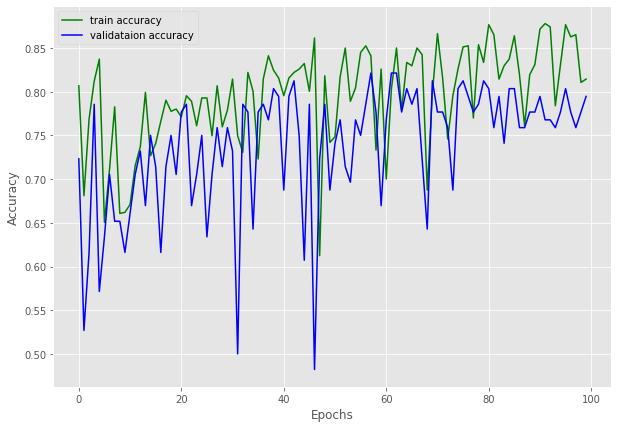

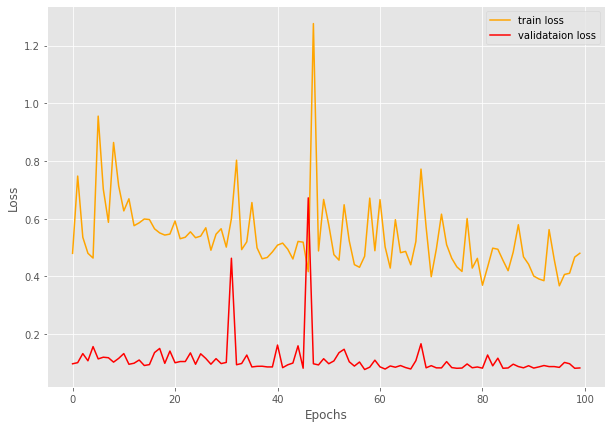

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
def save_plots_FCNet(train_acc, valid_acc, train_loss, valid_loss):
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('sample_data/accuracyFCNet.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('sample_data/lossFCNet.png')
# save the loss and accuracy plots
save_plots_FCNet(train_accuracies, val_accuracies, train_losses, val_losses)

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

Best model was saved at 58 epochs

Accuracy: 0.7610619469026548
Precision score is  0.7606142456982794
Recall score is  0.7606142456982794
F1 score is  0.7485346187811545


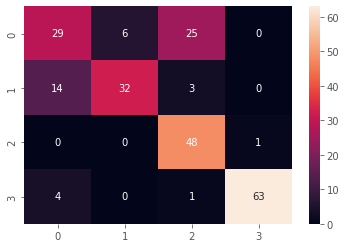

In [ ]:
is_gpu_available = torch.cuda.is_available()

# prepare the model
criterion = nn.CrossEntropyLoss()
conv_channels = [1024, 512, 256]
model = FCNet(conv_channels)
if is_gpu_available:
    model.cuda()

# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
# prepare test data loader
test_data_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)


# bring best model back
best_model_cp = torch.load('sample_data/bestModelFCNet.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

# load the state of best model
model.load_state_dict(best_model_cp['model_state_dict'])

model.eval()
correct_preds = 0
total_preds = 0
all_preds = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for batch_data, batch_labels in test_data_loader:
        batch_labels = batch_labels.type(torch.LongTensor) 
        batch_outputs = model(batch_data.view(-1, 3* 224* 224).to(torch.float32).cuda())
        # Calculate the accuracy
        # Max returns: (max_values, max_indices)
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
        all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
        all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)

# Report accuracy      
print("Accuracy: {}".format(correct_preds / total_preds))

# Report confusion matrix
confusion_matrix = torch.zeros(4, 4, dtype=torch.int64)
for label_idx in range(len(all_labels)):
    predicted = all_preds[label_idx].int()
    real = all_labels[label_idx].int()
    confusion_matrix[real, predicted] += 1

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix.numpy(), annot=True, fmt="d")
fig.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Report macro precision
ps = precision_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("Precision score is ", ps)
# Report macro recall
rs = recall_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("Recall score is ", ps)
# Report f1 score
f1 = f1_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("F1 score is ", f1)

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [10]:
is_gpu_available = torch.cuda.is_available()

# prepare the model
criterion = nn.CrossEntropyLoss()
conv_channels = [16, 32, 64]
model = ConvNet(conv_channels)
if is_gpu_available:
    model.cuda()

EX1: LEARNING RATE

For learning rate=  0.5
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Val loss for epoch: 1.0090480951162486
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.14010891547569862
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.10693138837814331
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.12752328010705802
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.09605770844679612
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.09674475743220402
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val loss for epoch: 0.0982254147529602
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.09630006093245286
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.09799308960254376
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.10048776406508225
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.12472246701900776
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.09056382454358615
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.10026018436138447
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.09026041397681603
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.086105438379141
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.08512079257231492
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.1025340327849755
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.10918981295365554
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Val loss for epoch: 0.08184622801267184
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.12123152384391198
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.08424832270695613
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Val loss for epoch: 0.10365768120839046
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.10811362358239981
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.09937283167472252
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.09608691472273606
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.1117365314410283
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.10144233245116013
Epoch: 28/50


100%|██████████| 13/13 [00:02<00:00,  6.01it/s]


Val loss for epoch: 0.10392745641561654
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.11109775304794312
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.11184300367648785
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.1307573364331172
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  7.59it/s]


Val loss for epoch: 0.09949583732164823
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Val loss for epoch: 0.10558048119911781
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Val loss for epoch: 0.1177444366308359
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.10545432567596436
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.1369312313886789
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.11045426588792068
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.15682639066989607
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.14333644280066857
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.13488026307179377
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.12877163061728844
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.13530152119123018
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.11535884325320904
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.12387361893287072
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.13034952603853667
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.11262340729053204
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.11421470917188205
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.15685705955211932
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Val loss for epoch: 0.14152645606261033
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.15795112114686233
For learning rate=  0.05
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.15292851283000067
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.140325862627763
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.13481926459532517
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.14271334959910467
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.3107980489730835
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.14593288990167472
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.14869639048209557
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


Val loss for epoch: 0.1439223702137287
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.15392165000622088
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.17075966413204485
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.1329334286543039
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.1497828593620887
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.14850099270160383
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.16664879597150362
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.14659885718272284
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.16175299882888794
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


Val loss for epoch: 0.15243341372563288
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.17887396078843337
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  7.68it/s]


Val loss for epoch: 0.14741316666969886
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Val loss for epoch: 0.14531086499874407
Epoch: 21/50


100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Val loss for epoch: 0.14916411271462074
Epoch: 22/50


100%|██████████| 13/13 [00:02<00:00,  4.90it/s]


Val loss for epoch: 0.14267263962672308
Epoch: 23/50


100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


Val loss for epoch: 0.16794093297078058
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  7.75it/s]


Val loss for epoch: 0.20642580435826227
Epoch: 25/50


100%|██████████| 13/13 [00:02<00:00,  6.11it/s]


Val loss for epoch: 0.16083499559989342
Epoch: 26/50


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Val loss for epoch: 0.19423745228694037
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.16566597956877488
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.16233335550014788
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.16925046535638663
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  7.41it/s]


Val loss for epoch: 0.16658791670432457
Epoch: 31/50


100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


Val loss for epoch: 0.18402899687106794
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


Val loss for epoch: 0.18613409537535447
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


Val loss for epoch: 0.17331223762952364
Epoch: 34/50


100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


Val loss for epoch: 0.18080089183954093
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Val loss for epoch: 0.18264686602812547
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


Val loss for epoch: 0.18506581966693586
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.18021332759123582
Epoch: 38/50


100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


Val loss for epoch: 0.1897283930044908
Epoch: 39/50


100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


Val loss for epoch: 0.19326370496016282
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.1866258428646968
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.18935915598502526
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Val loss for epoch: 0.19969064455765945
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.19522632543857282
Epoch: 44/50


100%|██████████| 13/13 [00:02<00:00,  6.21it/s]


Val loss for epoch: 0.18773153653511634
Epoch: 45/50


100%|██████████| 13/13 [00:02<00:00,  6.46it/s]


Val loss for epoch: 0.1932893074475802
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  7.75it/s]


Val loss for epoch: 0.19335339619563177
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.20137202739715576
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  7.60it/s]


Val loss for epoch: 0.20233879181054923
Epoch: 49/50


100%|██████████| 13/13 [00:02<00:00,  5.75it/s]


Val loss for epoch: 0.20799003197596624
Epoch: 50/50


100%|██████████| 13/13 [00:02<00:00,  5.66it/s]


Val loss for epoch: 0.19999956167661226
For learning rate=  0.005
Epoch: 1/50


100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


Val loss for epoch: 0.1986339413202726
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  7.71it/s]


Val loss for epoch: 0.20227891206741333
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


Val loss for epoch: 0.20344443504626936
Epoch: 4/50


100%|██████████| 13/13 [00:02<00:00,  5.99it/s]


Val loss for epoch: 0.20534654305531427
Epoch: 5/50


100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Val loss for epoch: 0.2066599543278034
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  6.59it/s]


Val loss for epoch: 0.20494550008040208
Epoch: 7/50


100%|██████████| 13/13 [00:02<00:00,  4.65it/s]


Val loss for epoch: 0.20756940658275896
Epoch: 8/50


100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Val loss for epoch: 0.21172540004436785
Epoch: 9/50


100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


Val loss for epoch: 0.21570176344651443
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Val loss for epoch: 0.20642918806809646
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


Val loss for epoch: 0.2070662470964285
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.21135947337517372
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.21224664724790132
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.2127739007656391
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.2110923803769625
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.21939553664280817
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.21777891195737398
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.2165960715367244
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  7.72it/s]


Val loss for epoch: 0.21388747141911432
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.21642719782315767
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  7.75it/s]


Val loss for epoch: 0.21691373678354117
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.21409235550807074
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.21804812321296105
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.22263829524700457
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.8629211645859939
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Val loss for epoch: 0.1457452911597032
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.12282694761569683
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.10130398548566379
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.09543262078211857
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.09634910638515766
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.10972941380280715
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.09852619813038753
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.09928784462121817
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.13658345204133254
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.10632549799405612
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.13873005371827346
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.10277075492418729
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.10425292070095356
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.11506446966758141
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.13353764552336472
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.11673041031910823
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Val loss for epoch: 0.14615331704799944
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.13249264313624456
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.1143982456280635
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val loss for epoch: 0.11304646730422974
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.23010515249692476
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  7.95it/s]


Val loss for epoch: 0.11669964056748611
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.11396950941819411
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.11818783558332004
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val loss for epoch: 0.12523229305560774
For learning rate=  0.0005
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.1737771721986624
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  7.94it/s]


Val loss for epoch: 0.1374155695621784
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.12827320740773127
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.13421097627052894
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.13191016820760873
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  7.75it/s]


Val loss for epoch: 0.1394459238419166
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.23897984394660363
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.14014984552676862
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.1399368139413687
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.14460405936607948
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Val loss for epoch: 0.14618985469524676
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.14638256568175095
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.1568550421641423
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.1631958668048565
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.16165808989451483
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.15498790374168983
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


Val loss for epoch: 0.1621894698876601
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.1608667648755587
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.16017276507157546
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.1614252649820768
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.16509361450488752
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Val loss for epoch: 0.16421700440920317
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.16602226404043344
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.16645018412516668
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.17117120210941023
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.17195215133520272
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.17067639644329363
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.1715031495461097
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.17653206678537223
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.1830837451494657
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.17454057931900024
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.17548777506901667
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val loss for epoch: 0.17919890697185809
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.17798903355231652
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.1780940844462468
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


Val loss for epoch: 0.1775612189219548
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.1790463374211238
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.17929825415978065
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.18023702731499305
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.17952528366675743
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.1806965424464299
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.18046724796295166
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.1830666890511146
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.18291902542114258
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.1831518319936899
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.1847724180955153
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.18362178252293512
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.18622003151820257
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Val loss for epoch: 0.18552765479454628
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


Val loss for epoch: 0.18577772837418777
For learning rate=  5e-05
Epoch: 1/50


100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Val loss for epoch: 0.18612126203683707
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Val loss for epoch: 0.18618777165046105
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.18668996370755708
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.1878963433779203
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.18651730280656081
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.1868065595626831
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.188442037655757
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Val loss for epoch: 0.18804677633138803
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.18828208629901594
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.19026329884162316
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.18953275680541992
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.18904189880077654
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.18944233197432297
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val loss for epoch: 0.18945679297814003
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.19013084815098688
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.19112907923184907
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Val loss for epoch: 0.18964123725891113
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.19018377707554743
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.191139817237854
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.19083147782545823
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.19151933376605695
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Val loss for epoch: 0.19137901526231033
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  7.94it/s]


Val loss for epoch: 0.19235632052788368
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.19292871768657976
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.1916910043129554
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.1938855739740225
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.1924396936710064
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  7.94it/s]


Val loss for epoch: 0.19283545017242432
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.19337313908797044
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.19339225842402533
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Val loss for epoch: 0.19329427755795991
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.1949691497362577
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.19443025955787072
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Val loss for epoch: 0.19299163268162653
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Val loss for epoch: 0.19375284818502572
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Val loss for epoch: 0.19470790716317984
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.19395190935868484
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Val loss for epoch: 0.19527788345630354
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Val loss for epoch: 0.19394072202535775
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Val loss for epoch: 0.19520394618694598
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.19495688951932466
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.19451337594252366
Epoch: 43/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.19546882005838248
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Val loss for epoch: 0.19421261090498704
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Val loss for epoch: 0.19569722505716178
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Val loss for epoch: 0.19480012930356538
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Val loss for epoch: 0.1948230266571045
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.01it/s]


Val loss for epoch: 0.19541291090158316
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.19558782760913557
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Val loss for epoch: 0.1948622098335853


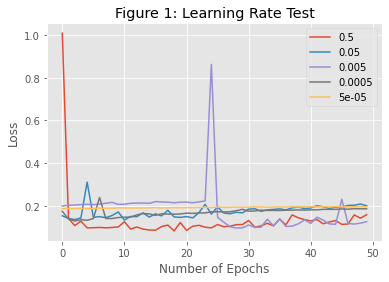

In [ ]:
# TODO: training loop + eval
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt

learning_rates = [5e-1, 5e-2, 5e-3, 5e-4, 5e-5]
accuracies_lr = [0, 0, 0, 0, 0]
for ler in learning_rates: 
  # Required components
  print("For learning rate= ", ler)
  train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
  val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
  optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.5, weight_decay = 5e-04) #params are selected by experiments

  # Training loop
  train_losses = []
  val_losses = []  
  no_of_epochs = 50
  iter_losses = []

  for epoch in range(no_of_epochs):
    train_running_loss = 0.0
    
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0
        sample_channel = np.transpose(batch_data, (0,3,2,1)) 
        batch_outputs = model( sample_channel.to(torch.float32).cuda() )
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
    train_losses.append(train_running_loss / len(train_data_loader))
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor) 
          sample_channel = np.transpose(batch_data, (0,3,2,1)) 
          batch_outputs = model( sample_channel.to(torch.float32).cuda() )
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_losses.append(val_epoch_loss)
  plt.plot(range(len(val_losses)), val_losses, label = ler)
  
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Figure 1: Learning Rate Test')
plt.legend()
plt.show()

EX2: EPOCH SIZE

Epoch: 1/100


100%|██████████| 13/13 [00:01<00:00,  7.28it/s]


Loss for epoch: 0.0011669685437272375
Epoch: 2/100


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Loss for epoch: 0.0011710233252065687
Epoch: 3/100


100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


Loss for epoch: 0.0011684901860112755
Epoch: 4/100


100%|██████████| 13/13 [00:02<00:00,  5.88it/s]


Loss for epoch: 0.0013489940924605785
Epoch: 5/100


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Loss for epoch: 0.0012185631427340782
Epoch: 6/100


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Loss for epoch: 0.0012001748008725161
Epoch: 7/100


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Loss for epoch: 0.0011538208793633832
Epoch: 8/100


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Loss for epoch: 0.0011913520731748296
Epoch: 9/100


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Loss for epoch: 0.0012121463928801508
Epoch: 10/100


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Loss for epoch: 0.0011599608249245929
Epoch: 11/100


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Loss for epoch: 0.0012281190944262422
Epoch: 12/100


100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Loss for epoch: 0.0011156162453027298
Epoch: 13/100


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Loss for epoch: 0.0011699946167377324
Epoch: 14/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.0011346132915395384
Epoch: 15/100


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Loss for epoch: 0.001183664018753916
Epoch: 16/100


100%|██████████| 13/13 [00:01<00:00,  7.71it/s]


Loss for epoch: 0.0011590729655626302
Epoch: 17/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.0011319647758052899
Epoch: 18/100


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Loss for epoch: 0.0011093097754592935
Epoch: 19/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.0011229365974521409
Epoch: 20/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.0011358148991488493
Epoch: 21/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Loss for epoch: 0.0011685768437858385
Epoch: 22/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0011256349702867179
Epoch: 23/100


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Loss for epoch: 0.0011417508671561687
Epoch: 24/100


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Loss for epoch: 0.0011210680822841823
Epoch: 25/100


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Loss for epoch: 0.0011094622649789716
Epoch: 26/100


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Loss for epoch: 0.0011829422885337127
Epoch: 27/100


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Loss for epoch: 0.0011459865938657178
Epoch: 28/100


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Loss for epoch: 0.001144484679501217
Epoch: 29/100


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Loss for epoch: 0.0011647419215968023
Epoch: 30/100


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Loss for epoch: 0.001122136958516561
Epoch: 31/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.001188038109550969
Epoch: 32/100


100%|██████████| 13/13 [00:01<00:00,  7.94it/s]


Loss for epoch: 0.0011695466640118796
Epoch: 33/100


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Loss for epoch: 0.0011654064560738893
Epoch: 34/100


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Loss for epoch: 0.0011419723696935063
Epoch: 35/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Loss for epoch: 0.001168509479612112
Epoch: 36/100


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Loss for epoch: 0.0011036734347446607
Epoch: 37/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0011403662994360696
Epoch: 38/100


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Loss for epoch: 0.0011884535600144702
Epoch: 39/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Loss for epoch: 0.0011559442903559941
Epoch: 40/100


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Loss for epoch: 0.0011539116295842598
Epoch: 41/100


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Loss for epoch: 0.0011544684306360208
Epoch: 42/100


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Loss for epoch: 0.0011029021362236773
Epoch: 43/100


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Loss for epoch: 0.0011478358937893063
Epoch: 44/100


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Loss for epoch: 0.0012234016612637788
Epoch: 45/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Loss for epoch: 0.0011540589934716432
Epoch: 46/100


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Loss for epoch: 0.0011095726490916254
Epoch: 47/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Loss for epoch: 0.0011221504358288187
Epoch: 48/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.0011491424430949758
Epoch: 49/100


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Loss for epoch: 0.0011456570847747992
Epoch: 50/100


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Loss for epoch: 0.0011720081585316132
Epoch: 51/100


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Loss for epoch: 0.0011354757813163674
Epoch: 52/100


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Loss for epoch: 0.0011211334315773386
Epoch: 53/100


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Loss for epoch: 0.0011643136206727761
Epoch: 54/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.0011434843629383696
Epoch: 55/100


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Loss for epoch: 0.001142883283766703
Epoch: 56/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.0011930208823357064
Epoch: 57/100


100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Loss for epoch: 0.0011473480419506533
Epoch: 58/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0011070609056892304
Epoch: 59/100


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Loss for epoch: 0.0011464824828390891
Epoch: 60/100


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Loss for epoch: 0.0011348840108929346
Epoch: 61/100


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Loss for epoch: 0.0011699574936826068
Epoch: 62/100


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Loss for epoch: 0.0010811022931683022
Epoch: 63/100


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Loss for epoch: 0.0011961626990411717
Epoch: 64/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.0011502965666855185
Epoch: 65/100


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Loss for epoch: 0.0011569369100750638
Epoch: 66/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0011223469986222112
Epoch: 67/100


100%|██████████| 13/13 [00:02<00:00,  5.85it/s]


Loss for epoch: 0.0011440197435709147
Epoch: 68/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.001147364870680926
Epoch: 69/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.0010843095739031783
Epoch: 70/100


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Loss for epoch: 0.0011026640915168594
Epoch: 71/100


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Loss for epoch: 0.001162795920838387
Epoch: 72/100


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Loss for epoch: 0.0010868079776768214
Epoch: 73/100


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Loss for epoch: 0.0011153519690896457
Epoch: 74/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.0011550439969421579
Epoch: 75/100


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Loss for epoch: 0.0011458068620413542
Epoch: 76/100


100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Loss for epoch: 0.001100856598126344
Epoch: 77/100


100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Loss for epoch: 0.0011435928754508495
Epoch: 78/100


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Loss for epoch: 0.001126411670926385
Epoch: 79/100


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Loss for epoch: 0.00110712534828613
Epoch: 80/100


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Loss for epoch: 0.0011082437167015786
Epoch: 81/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0011145242158538448
Epoch: 82/100


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Loss for epoch: 0.0011432367117287447
Epoch: 83/100


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


Loss for epoch: 0.0011273879566803002
Epoch: 84/100


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Loss for epoch: 0.0011603828170336783
Epoch: 85/100


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Loss for epoch: 0.0010915819282392757
Epoch: 86/100


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Loss for epoch: 0.0011906932475260245
Epoch: 87/100


100%|██████████| 13/13 [00:01<00:00,  7.75it/s]


Loss for epoch: 0.0012466889725496562
Epoch: 88/100


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Loss for epoch: 0.0011117968130677652
Epoch: 89/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0011178448509711486
Epoch: 90/100


100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Loss for epoch: 0.0010889600380323827
Epoch: 91/100


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Loss for epoch: 0.0011197224823543085
Epoch: 92/100


100%|██████████| 13/13 [00:01<00:00,  7.67it/s]


Loss for epoch: 0.001128504339319009
Epoch: 93/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0010938980468871216
Epoch: 94/100


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Loss for epoch: 0.0011046592128248168
Epoch: 95/100


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Loss for epoch: 0.001080480041519667
Epoch: 96/100


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


Loss for epoch: 0.0010975773598497303
Epoch: 97/100


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Loss for epoch: 0.0011196140146169525
Epoch: 98/100


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


Loss for epoch: 0.0010942189255729318
Epoch: 99/100


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


Loss for epoch: 0.001100967826250081
Epoch: 100/100


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


Loss for epoch: 0.001110984505010912


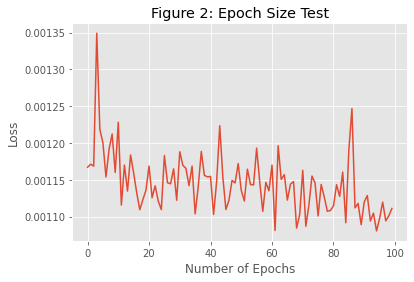

The best loss value is  0.001080480041519667  achieved by  95


In [ ]:
learning_rate = 5e-3 # We pick the best - most stable learning rate from experiment results
no_of_epochs = 100
minYieldingEpoch = -1 
minloss = 1

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5, weight_decay = 5e-04)
# Training loop
iter_losses = []
epoch_losses = []
for epoch in range(no_of_epochs):
  running_loss = 0.0
  print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
  for batch_data, batch_labels in tqdm(train_data_loader):
      batch_labels = batch_labels.type(torch.LongTensor) 
      optimizer.zero_grad() # Setting the starting gradients as 0
      sample_channel = np.transpose(batch_data, (0,3,2,1)) 
      batch_outputs = model( sample_channel.to(torch.float32).cuda() )
      loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) # Calculate the loss
      loss.backward() # Calculate the gradients
      optimizer.step() # Update the weights
      iter_losses.append(loss.item())
      running_loss += loss.item()
 
  if running_loss / len(train_data_loader) <= minloss:
    minYieldingEpoch = epoch + 1
    minloss = running_loss / len(train_data_loader)
  epoch_losses.append(running_loss / len(train_data_loader))
  print("Loss for epoch: {}".format(running_loss / len(train_data_loader)))

plt.plot(range(len(epoch_losses)), epoch_losses, label = learning_rate)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Figure 2: Epoch Size Test')
plt.show()

print("The best loss value is ", minloss, " achieved by ", minYieldingEpoch)

EX3: BATCH SIZE 

For batch size=  64
Epoch: 1/50


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Val loss for epoch: 0.24520437534038836
Epoch: 2/50


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Val loss for epoch: 0.06907342030451848
Epoch: 3/50


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Val loss for epoch: 0.07509119235552274
Epoch: 4/50


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Val loss for epoch: 0.0717428785104018
Epoch: 5/50


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Val loss for epoch: 0.06502634745377761
Epoch: 6/50


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Val loss for epoch: 0.06782841682434082
Epoch: 7/50


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Val loss for epoch: 0.08269552542613103
Epoch: 8/50


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Val loss for epoch: 0.05829255168254559
Epoch: 9/50


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Val loss for epoch: 0.05774065164419321
Epoch: 10/50


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Val loss for epoch: 0.05929273825425368
Epoch: 11/50


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Val loss for epoch: 0.06862511543127206
Epoch: 12/50


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Val loss for epoch: 0.055193036794662476
Epoch: 13/50


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Val loss for epoch: 0.0672663885813493
Epoch: 14/50


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Val loss for epoch: 0.05638853632486784
Epoch: 15/50


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Val loss for epoch: 0.05236255320218893
Epoch: 16/50


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Val loss for epoch: 0.054253652691841125
Epoch: 17/50


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Val loss for epoch: 0.06262918848257798
Epoch: 18/50


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.05500913124818068
Epoch: 19/50


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Val loss for epoch: 0.07051978432215177
Epoch: 20/50


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Val loss for epoch: 0.09909890935971187
Epoch: 21/50


100%|██████████| 13/13 [00:01<00:00,  8.32it/s]


Val loss for epoch: 0.05148486449168278
Epoch: 22/50


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Val loss for epoch: 0.05487733162366427
Epoch: 23/50


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Val loss for epoch: 0.08227095007896423
Epoch: 24/50


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Val loss for epoch: 0.08180917684848492
Epoch: 25/50


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Val loss for epoch: 0.046596603897901684
Epoch: 26/50


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Val loss for epoch: 0.048020271154550404
Epoch: 27/50


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.061008572578430176
Epoch: 28/50


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.08261713156333336
Epoch: 29/50


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.04442433325143961
Epoch: 30/50


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Val loss for epoch: 0.06111239011471088
Epoch: 31/50


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Val loss for epoch: 0.07775183365895198
Epoch: 32/50


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Val loss for epoch: 0.0744361808666816
Epoch: 33/50


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.07555675965089065
Epoch: 34/50


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.06105269835545467
Epoch: 35/50


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Val loss for epoch: 0.06342225120617793
Epoch: 36/50


100%|██████████| 13/13 [00:01<00:00,  6.62it/s]


Val loss for epoch: 0.056493126429044284
Epoch: 37/50


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.05128748371050908
Epoch: 38/50


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Val loss for epoch: 0.08612032120044415
Epoch: 39/50


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.06650904279488784
Epoch: 40/50


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Val loss for epoch: 0.05932691693305969
Epoch: 41/50


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.06410112747779259
Epoch: 42/50


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.06692067247170669
Epoch: 43/50


100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Val loss for epoch: 0.06134246404354389
Epoch: 44/50


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.05937702839191143
Epoch: 45/50


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


Val loss for epoch: 0.07801990784131564
Epoch: 46/50


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.05303154083398672
Epoch: 47/50


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.07291859617600074
Epoch: 48/50


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Val loss for epoch: 0.06514381216122554
Epoch: 49/50


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Val loss for epoch: 0.07261499762535095
Epoch: 50/50


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Val loss for epoch: 0.06721818447113037
For batch size=  150
Epoch: 1/50


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Val loss for epoch: 0.060146182775497437
Epoch: 2/50


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Val loss for epoch: 0.06413293381532033
Epoch: 3/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.06514587998390198
Epoch: 4/50


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Val loss for epoch: 0.06344771385192871
Epoch: 5/50


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Val loss for epoch: 0.06414299706617992
Epoch: 6/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.06139238675435384
Epoch: 7/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.06643141806125641
Epoch: 8/50


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Val loss for epoch: 0.06452720363934834
Epoch: 9/50


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Val loss for epoch: 0.06895276407400767
Epoch: 10/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.06811957557996114
Epoch: 11/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.06365843117237091
Epoch: 12/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.06442125638326009
Epoch: 13/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.07076260944207509
Epoch: 14/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.07387875020503998
Epoch: 15/50


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Val loss for epoch: 0.06809517741203308
Epoch: 16/50


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Val loss for epoch: 0.08595378200213115
Epoch: 17/50


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Val loss for epoch: 0.0742348978916804
Epoch: 18/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.06610726316769917
Epoch: 19/50


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Val loss for epoch: 0.07287291685740153
Epoch: 20/50


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Val loss for epoch: 0.06966142356395721
Epoch: 21/50


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Val loss for epoch: 0.07281037668387096
Epoch: 22/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.06793021162350972
Epoch: 23/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.07093821465969086
Epoch: 24/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.07094306250413258
Epoch: 25/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.07572967807451884
Epoch: 26/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.0736307551463445
Epoch: 27/50


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Val loss for epoch: 0.07140837609767914
Epoch: 28/50


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Val loss for epoch: 0.07541267077128093
Epoch: 29/50


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Val loss for epoch: 0.07094619174798329
Epoch: 30/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.07075304786364238
Epoch: 31/50


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Val loss for epoch: 0.08688169717788696
Epoch: 32/50


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Val loss for epoch: 0.11079409718513489
Epoch: 33/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.0757465809583664
Epoch: 34/50


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


Val loss for epoch: 0.07788479328155518
Epoch: 35/50


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Val loss for epoch: 0.07735792795817058
Epoch: 36/50


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Val loss for epoch: 0.07811282575130463
Epoch: 37/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.07755713164806366
Epoch: 38/50


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Val loss for epoch: 0.07807134588559468
Epoch: 39/50


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Val loss for epoch: 0.07610049843788147
Epoch: 40/50


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Val loss for epoch: 0.08449910084406535
Epoch: 41/50


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Val loss for epoch: 0.07784475386142731
Epoch: 42/50


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Val loss for epoch: 0.07919735213120778
Epoch: 43/50


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


Val loss for epoch: 0.07525420685609181
Epoch: 44/50


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Val loss for epoch: 0.07756125430266063
Epoch: 45/50


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Val loss for epoch: 0.08294062316417694
Epoch: 46/50


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Val loss for epoch: 0.07953595121701558
Epoch: 47/50


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Val loss for epoch: 0.07654817402362823
Epoch: 48/50


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Val loss for epoch: 0.07999112705389659
Epoch: 49/50


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Val loss for epoch: 0.08023215333620708
Epoch: 50/50


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Val loss for epoch: 0.07835347453753154
For batch size=  300
Epoch: 1/50


100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


Val loss for epoch: 0.15691508849461874
Epoch: 2/50


100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


Val loss for epoch: 0.1580150028069814
Epoch: 3/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.15796826283137003
Epoch: 4/50


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Val loss for epoch: 0.15916937589645386
Epoch: 5/50


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Val loss for epoch: 0.15987918774286905
Epoch: 6/50


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Val loss for epoch: 0.1606730024019877
Epoch: 7/50


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Val loss for epoch: 0.16056998570760092
Epoch: 8/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16695129871368408
Epoch: 9/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16193658113479614
Epoch: 10/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.15742277105649313
Epoch: 11/50


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Val loss for epoch: 0.160543292760849
Epoch: 12/50


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Val loss for epoch: 0.1599800487359365
Epoch: 13/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.16122973958651224
Epoch: 14/50


100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Val loss for epoch: 0.16167218486467996
Epoch: 15/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.16146416465441385
Epoch: 16/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.1613869865735372
Epoch: 17/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16158705949783325
Epoch: 18/50


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Val loss for epoch: 0.16209243734677634
Epoch: 19/50


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Val loss for epoch: 0.16328699390093485
Epoch: 20/50


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Val loss for epoch: 0.1621632476647695
Epoch: 21/50


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Val loss for epoch: 0.1625421643257141
Epoch: 22/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16089209914207458
Epoch: 23/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16252419352531433
Epoch: 24/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16424314181009927
Epoch: 25/50


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Val loss for epoch: 0.1632434825102488
Epoch: 26/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.1625139812628428
Epoch: 27/50


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Val loss for epoch: 0.16210038463274637
Epoch: 28/50


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Val loss for epoch: 0.1629182994365692
Epoch: 29/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16284912824630737
Epoch: 30/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.16322708129882812
Epoch: 31/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.1634677549203237
Epoch: 32/50


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Val loss for epoch: 0.16388792792956033
Epoch: 33/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.16421636939048767
Epoch: 34/50


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Val loss for epoch: 0.16417112946510315
Epoch: 35/50


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Val loss for epoch: 0.164190540711085
Epoch: 36/50


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Val loss for epoch: 0.1656766136487325
Epoch: 37/50


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Val loss for epoch: 0.16565356651941934
Epoch: 38/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.1644615431626638
Epoch: 39/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.16522977749506632
Epoch: 40/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.1654361883799235
Epoch: 41/50


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Val loss for epoch: 0.166246235370636
Epoch: 42/50


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Val loss for epoch: 0.1650482714176178
Epoch: 43/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.1656335989634196
Epoch: 44/50


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Val loss for epoch: 0.1662213702996572
Epoch: 45/50


100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Val loss for epoch: 0.1654091775417328
Epoch: 46/50


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Val loss for epoch: 0.1657382051150004
Epoch: 47/50


100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Val loss for epoch: 0.1664361854394277
Epoch: 48/50


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Val loss for epoch: 0.16640233000119528
Epoch: 49/50


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Val loss for epoch: 0.1672749916712443
Epoch: 50/50


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Val loss for epoch: 0.16718266407648721
For batch size=  787
Epoch: 1/50


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Val loss for epoch: 0.5013158917427063
Epoch: 2/50


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Val loss for epoch: 0.5011204481124878
Epoch: 3/50


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Val loss for epoch: 0.500991940498352
Epoch: 4/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5009416341781616
Epoch: 5/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5009540319442749
Epoch: 6/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5010078549385071
Epoch: 7/50


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Val loss for epoch: 0.5011037588119507
Epoch: 8/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5012405514717102
Epoch: 9/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5014058351516724
Epoch: 10/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.501587450504303
Epoch: 11/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5017761588096619
Epoch: 12/50


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Val loss for epoch: 0.5019667148590088
Epoch: 13/50


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Val loss for epoch: 0.5021579265594482
Epoch: 14/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5023470520973206
Epoch: 15/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5025321841239929
Epoch: 16/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.502713680267334
Epoch: 17/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5028907656669617
Epoch: 18/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5030625462532043
Epoch: 19/50


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Val loss for epoch: 0.5032268166542053
Epoch: 20/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5033875703811646
Epoch: 21/50


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Val loss for epoch: 0.5035451054573059
Epoch: 22/50


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Val loss for epoch: 0.5037010312080383
Epoch: 23/50


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Val loss for epoch: 0.5038565993309021
Epoch: 24/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5040108561515808
Epoch: 25/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5041651725769043
Epoch: 26/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5043193101882935
Epoch: 27/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5044755339622498
Epoch: 28/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5046306848526001
Epoch: 29/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5047826170921326
Epoch: 30/50


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Val loss for epoch: 0.5049347281455994
Epoch: 31/50


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Val loss for epoch: 0.5050867199897766
Epoch: 32/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5052393674850464
Epoch: 33/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5053925514221191
Epoch: 34/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5055461525917053
Epoch: 35/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5057007670402527
Epoch: 36/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5058544278144836
Epoch: 37/50


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Val loss for epoch: 0.5060076713562012
Epoch: 38/50


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Val loss for epoch: 0.506158709526062
Epoch: 39/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5063095688819885
Epoch: 40/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5064620971679688
Epoch: 41/50


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Val loss for epoch: 0.5066145658493042
Epoch: 42/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5067659020423889
Epoch: 43/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5069150328636169
Epoch: 44/50


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Val loss for epoch: 0.5070624351501465
Epoch: 45/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5072090029716492
Epoch: 46/50


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Val loss for epoch: 0.5073550939559937
Epoch: 47/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.507500946521759
Epoch: 48/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5076464414596558
Epoch: 49/50


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Val loss for epoch: 0.5077915787696838
Epoch: 50/50


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Val loss for epoch: 0.5079370141029358


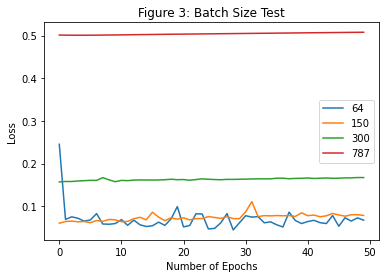

In [11]:
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt

atch_sizes = [64, 150, 300, train_dataset.__len__() ]
from tqdm import tqdm
for batch in batch_sizes: 
  # Required components
  print("For batch size= ", batch)
  train_data_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True) 
  val_data_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
  optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.5, weight_decay = 5e-04) #params are selected by experiments

  # Training loop
  train_losses = []
  val_losses = []  
  no_of_epochs = 50
  iter_losses = []

  for epoch in range(no_of_epochs):
    train_running_loss = 0.0
    
    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0
        sample_channel = np.transpose(batch_data, (0,3,2,1)) 
        batch_outputs = model( sample_channel.to(torch.float32).cuda() )
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
    train_losses.append(train_running_loss / len(train_data_loader))
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor) 
          sample_channel = np.transpose(batch_data, (0,3,2,1)) 
          batch_outputs = model( sample_channel.to(torch.float32).cuda() )
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_losses.append(val_epoch_loss)
  plt.plot(range(len(val_losses)), val_losses, label = batch)
  
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Figure 3: Batch Size Test')
plt.legend()
plt.show()

In [ ]:
class SaveBestModelConvNet:
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'sample_data/bestModelConvNet.pth')

In [ ]:
# Required components
from tqdm import tqdm
from torch import optim
import matplotlib.pyplot as plt

train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.5, weight_decay = 5e-04) #params are selected by experiments
save_best_model_ConvNet = SaveBestModelConvNet()

from tqdm import tqdm
# Training loop
train_accuracies = []
train_losses = []

val_losses = []
val_accuracies = []

no_of_epochs = 100
iter_losses = []


for epoch in range(no_of_epochs):
    #model.train()
    train_running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    print("Epoch: {}/{}".format(epoch + 1, no_of_epochs))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0
        sample_channel = np.transpose(batch_data, (0,3,2,1)) 
        batch_outputs = model( sample_channel.to(torch.float32).cuda() )
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
        # Calculate the accuracy
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        #pred_labels = pred_labels.to("cuda")
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
        all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
        all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)
    train_losses.append(train_running_loss / len(train_data_loader))
    train_accuracies.append(correct_preds / total_preds)

    model.eval()
    val_running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor) 
          sample_channel = np.transpose(batch_data, (0,3,2,1)) 
          batch_outputs = model( sample_channel.to(torch.float32).cuda() )
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
          # Calculate the accuracy
          # Max returns: (max_values, max_indices)
          # We only need the indices to assess the predictions
          _, pred_labels = torch.max(batch_outputs, dim=1)
          total_preds += pred_labels.size(0)
          correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
          all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
          all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)
      #print("Accuracy: {}".format(correct_preds / total_preds))
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(correct_preds / total_preds)

    #Save best model
    save_best_model_ConvNet(
        val_epoch_loss, epoch, model, optimizer, criterion
    )

print('TRAINING COMPLETE')    
print("Finished Training Best Model!")

Epoch: 1/100


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Val loss for epoch: 0.24520437534038836
Epoch: 2/100


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.06907342030451848
Epoch: 3/100


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Val loss for epoch: 0.07509119235552274
Epoch: 4/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.0717428785104018
Epoch: 5/100


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Val loss for epoch: 0.06502634745377761
Epoch: 6/100


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.06782841682434082
Epoch: 7/100


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.08269552542613103
Epoch: 8/100


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.05829255168254559
Epoch: 9/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.05774065164419321
Epoch: 10/100


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Val loss for epoch: 0.05929273825425368
Epoch: 11/100


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.06862511543127206
Epoch: 12/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.055193036794662476
Epoch: 13/100


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Val loss for epoch: 0.0672663885813493
Epoch: 14/100


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Val loss for epoch: 0.05638853632486784
Epoch: 15/100


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Val loss for epoch: 0.05236255320218893
Epoch: 16/100


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.054253652691841125
Epoch: 17/100


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


Val loss for epoch: 0.06262918848257798
Epoch: 18/100


100%|██████████| 13/13 [00:01<00:00,  8.21it/s]


Val loss for epoch: 0.05500913124818068
Epoch: 19/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.07051978432215177
Epoch: 20/100


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Val loss for epoch: 0.09909890935971187
Epoch: 21/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.05148486449168278
Epoch: 22/100


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.05487733162366427
Epoch: 23/100


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Val loss for epoch: 0.08227095007896423
Epoch: 24/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.08180917684848492
Epoch: 25/100


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Val loss for epoch: 0.046596603897901684
Epoch: 26/100


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Val loss for epoch: 0.048020271154550404
Epoch: 27/100


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.061008572578430176
Epoch: 28/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.08261713156333336
Epoch: 29/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.04442433325143961
Epoch: 30/100


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Val loss for epoch: 0.06111239011471088
Epoch: 31/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.07775183365895198
Epoch: 32/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.0744361808666816
Epoch: 33/100


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.07555675965089065
Epoch: 34/100


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.06105269835545467
Epoch: 35/100


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Val loss for epoch: 0.06342225120617793
Epoch: 36/100


100%|██████████| 13/13 [00:01<00:00,  8.21it/s]


Val loss for epoch: 0.056493126429044284
Epoch: 37/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.05128748371050908
Epoch: 38/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.08612032120044415
Epoch: 39/100


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Val loss for epoch: 0.06650904279488784
Epoch: 40/100


100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


Val loss for epoch: 0.05932691693305969
Epoch: 41/100


100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Val loss for epoch: 0.06410112747779259
Epoch: 42/100


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Val loss for epoch: 0.06692067247170669
Epoch: 43/100


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


Val loss for epoch: 0.06134246404354389
Epoch: 44/100


100%|██████████| 13/13 [00:01<00:00,  7.62it/s]


Val loss for epoch: 0.05937702839191143
Epoch: 45/100


100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Val loss for epoch: 0.07801990784131564
Epoch: 46/100


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.05303154083398672
Epoch: 47/100


100%|██████████| 13/13 [00:01<00:00,  8.15it/s]


Val loss for epoch: 0.07291859617600074
Epoch: 48/100


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Val loss for epoch: 0.06514381216122554
Epoch: 49/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.07261499762535095
Epoch: 50/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.06721818447113037
Epoch: 51/100


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Val loss for epoch: 0.052058158012536854
Epoch: 52/100


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Val loss for epoch: 0.0688774769122784
Epoch: 53/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.05421618544138395
Epoch: 54/100


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.06629374394050011
Epoch: 55/100


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Val loss for epoch: 0.06349860934110788
Epoch: 56/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.05876693588036757
Epoch: 57/100


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Val loss for epoch: 0.07218126379526578
Epoch: 58/100


100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Val loss for epoch: 0.06759729293676522
Epoch: 59/100


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Val loss for epoch: 0.08182249619410588
Epoch: 60/100


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


Val loss for epoch: 0.07441728848677415
Epoch: 61/100


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Val loss for epoch: 0.07592264276284438
Epoch: 62/100


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.07672865344927861
Epoch: 63/100


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.07174615905835079
Epoch: 64/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.07520827880272499
Epoch: 65/100


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Val loss for epoch: 0.07142025920060965
Epoch: 66/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.07560430811001705
Epoch: 67/100


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.07334020504584679
Epoch: 68/100


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.07553584300554715
Epoch: 69/100


100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Val loss for epoch: 0.08701203878109272
Epoch: 70/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.07317655820112962
Epoch: 71/100


100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Val loss for epoch: 0.08014631729859573
Epoch: 72/100


100%|██████████| 13/13 [00:01<00:00,  8.04it/s]


Val loss for epoch: 0.08588870672079232
Epoch: 73/100


100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


Val loss for epoch: 0.08083001466897818
Epoch: 74/100


100%|██████████| 13/13 [00:01<00:00,  8.02it/s]


Val loss for epoch: 0.08739175704809335
Epoch: 75/100


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


Val loss for epoch: 0.08787873158088097
Epoch: 76/100


100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Val loss for epoch: 0.0924629752452557
Epoch: 77/100


100%|██████████| 13/13 [00:01<00:00,  8.02it/s]


Val loss for epoch: 0.08099997272858253
Epoch: 78/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.08277653272335346
Epoch: 79/100


100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


Val loss for epoch: 0.08254622037594135
Epoch: 80/100


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Val loss for epoch: 0.08038195738425621
Epoch: 81/100


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.08164803339884831
Epoch: 82/100


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


Val loss for epoch: 0.09058378751461323
Epoch: 83/100


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Val loss for epoch: 0.08900704062902011
Epoch: 84/100


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Val loss for epoch: 0.08896755255185641
Epoch: 85/100


100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


Val loss for epoch: 0.08954641222953796
Epoch: 86/100


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Val loss for epoch: 0.08905308063213642
Epoch: 87/100


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.08645905898167537
Epoch: 88/100


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.0874104224718534
Epoch: 89/100


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


Val loss for epoch: 0.09774852257508498
Epoch: 90/100


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Val loss for epoch: 0.11770390088741596
Epoch: 91/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.07461457298352168
Epoch: 92/100


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


Val loss for epoch: 0.08863429381297185
Epoch: 93/100


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.07274101789181049
Epoch: 94/100


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


Val loss for epoch: 0.08547329673400292
Epoch: 95/100


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Val loss for epoch: 0.08677833355390109
Epoch: 96/100


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Val loss for epoch: 0.08798161149024963
Epoch: 97/100


100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Val loss for epoch: 0.08424032422212455
Epoch: 98/100


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.08772086180173434
Epoch: 99/100


100%|██████████| 13/13 [00:01<00:00,  7.99it/s]


Val loss for epoch: 0.09077202815275925
Epoch: 100/100


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Val loss for epoch: 0.09078123936286339
TRAINING COMPLETE
Finished Training Best Model!


### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

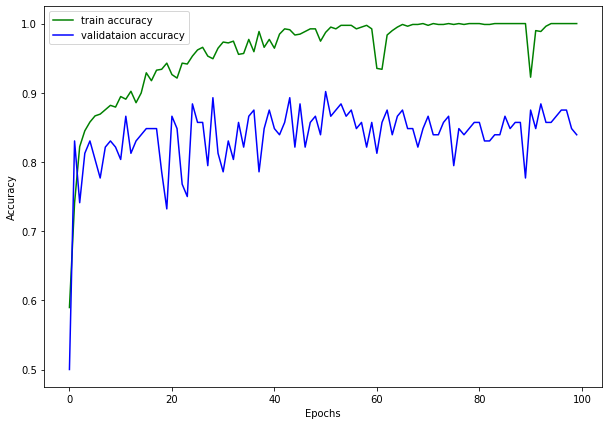

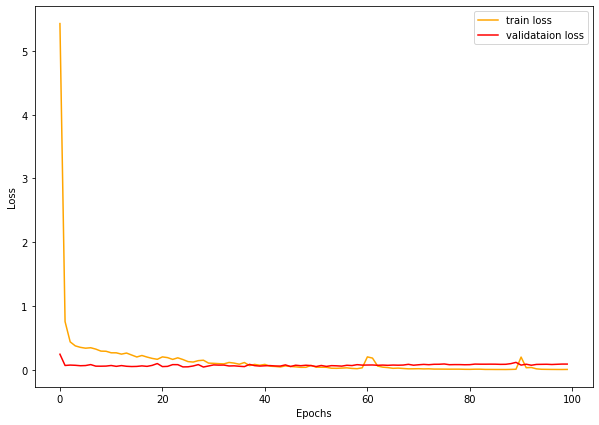

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
def save_plots_convnet(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('sample_data/accuracyConvNet.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('sample_data/lossConvNet.png')
# save the loss and accuracy plots
save_plots_convnet(train_accuracies, val_accuracies, train_losses, val_losses)

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

Best model was saved at 29 epochs

Accuracy: 0.8495575221238938
Precision score is  0.8439475790316127
Recall score is  0.8439475790316127
F1 score is  0.8423873613263682


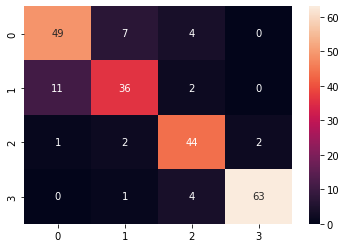

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
is_gpu_available = torch.cuda.is_available()

# prepare the model
criterion = nn.CrossEntropyLoss()
conv_channels = [16, 32, 64]
model = ConvNet(conv_channels)
if is_gpu_available:
    model.cuda()

# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
# prepare test data loader
test_data_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

# bring best model back
best_model_cp = torch.load('sample_data/bestModelConvNet.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

# load the state of best model
model.load_state_dict(best_model_cp['model_state_dict'])

model.eval()
correct_preds = 0
total_preds = 0
all_preds = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for batch_data, batch_labels in test_data_loader:
        batch_labels = batch_labels.type(torch.LongTensor) 
        sample_channel = np.transpose(batch_data, (0,3,2,1)) 
        batch_outputs = model( sample_channel.to(torch.float32).cuda() )
        # Calculate the accuracy
        # Max returns: (max_values, max_indices)
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
        all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
        all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)

# Report accuracy      
print("Accuracy: {}".format(correct_preds / total_preds))

# Report confusion matrix
confusion_matrix = torch.zeros(4, 4, dtype=torch.int64)
for label_idx in range(len(all_labels)):
    predicted = all_preds[label_idx].int()
    real = all_labels[label_idx].int()
    confusion_matrix[real, predicted] += 1

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix.numpy(), annot=True, fmt="d")
fig.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Report macro precision
ps = precision_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("Precision score is ", ps)
# Report macro recall
rs = recall_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("Recall score is ", ps)
# Report f1 score
f1 = f1_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("F1 score is ", f1)

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

In comparison to fully connected network, the number of parameters are significantly lower in the convolutional network. Furthermore, using ConvNet also results in train and validation accuracy to develop much closer to each other when compared to fully connected network. The results demonstrated that, for our classification case, overall accuracy results came close for the two selected distinct network architectures with similar hyperparameter choices. In essence, a FCN has much more parameters/weights to compute and train wheras CNN's try to solve this by trying to focus on most useful features by having much less parameters.

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

###Training [12 points]

In [ ]:
class SaveBestModelTL:
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'sample_data/bestModelTL.pth')
            
def build_model_TL(num_classes=4):
    model = torchvision.models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [ ]:
#HINT: note that your training time should not take many days.
#TODO:
from torch import optim
criterion = nn.CrossEntropyLoss()
#Pick your hyper parameters
max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 9e-2
weight_decay = 5e-04

# TODO: Implement training loop + eval using ResNet-18 model
model = build_model_TL(num_classes=4)
model.cuda()

# Required components
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=9e-2, momentum=0.5, weight_decay=5e-04) #params are selected by experiments
save_best_model_TL = SaveBestModelTL()

from tqdm import tqdm
# Training loop
train_accuracies = []
train_losses = []

val_losses = []
val_accuracies = []

iter_losses = []

for epoch in range(max_epoch):
    train_running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    print("Epoch: {}/{}".format(epoch + 1, max_epoch))
    for batch_data, batch_labels in tqdm(train_data_loader):
        batch_labels = batch_labels.type(torch.LongTensor) 
        optimizer.zero_grad() # Setting the starting gradients as 0

        sample_channel = np.transpose(batch_data, (0,3,2,1))
        #myview = batch_data.view(-1, 3, 224, 224)
        #batch_outputs = model( batch_data.view(-1, 3, 224, 224).to(torch.float32).cuda() ) # Predict outputs
        batch_outputs = model( sample_channel.to(torch.float32).cuda() ) # Predict outputs
        
        # Calculate the loss
        loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
        loss.backward() # Calculate the gradients
        optimizer.step() # Update the weights
        iter_losses.append(loss.item())
        train_running_loss += loss.item()
        # Calculate the accuracy
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        #pred_labels = pred_labels.to("cuda")
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
        all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
        all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)
    train_losses.append(train_running_loss / len(train_data_loader))
    train_accuracies.append(correct_preds / total_preds)

    model.eval()
    val_running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
      for batch_data, batch_labels in val_data_loader:
          batch_labels = batch_labels.type(torch.LongTensor)
          sample_channel = np.transpose(batch_data, (0,3,2,1)) 
          batch_outputs = model( sample_channel.to(torch.float32).cuda() )
          # Calculate the loss
          loss = criterion(batch_outputs.cuda(), batch_labels.cuda()) 
          val_running_loss += loss.item()
          # Calculate the accuracy
          # Max returns: (max_values, max_indices)
          # We only need the indices to assess the predictions
          _, pred_labels = torch.max(batch_outputs, dim=1)
          total_preds += pred_labels.size(0)
          correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
          all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
          all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)
    val_epoch_loss = val_running_loss / len(train_data_loader) 
    print("Val loss for epoch: {}".format(val_running_loss / len(train_data_loader)))
    val_accuracy = correct_preds / total_preds
    val_losses.append(val_epoch_loss)
    val_accuracies.append(correct_preds / total_preds)

    #Save best model
    save_best_model_TL(
        val_epoch_loss, epoch, model, optimizer, criterion
    )

print("Finished Training Best Model!")




/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10


100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Val loss for epoch: 0.08763039112091064
Epoch: 2/10


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.027769222855567932
Epoch: 3/10


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Val loss for epoch: 0.06428936353096595
Epoch: 4/10


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


Val loss for epoch: 0.014464618494877448
Epoch: 5/10


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Val loss for epoch: 0.017118151371295635
Epoch: 6/10


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Val loss for epoch: 0.031317195640160486
Epoch: 7/10


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Val loss for epoch: 0.014905130060819479
Epoch: 8/10


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


Val loss for epoch: 0.02113068734224026
Epoch: 9/10


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.013842618809296535
Epoch: 10/10


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Val loss for epoch: 0.013456500207002346
Finished Training Best Model!


###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

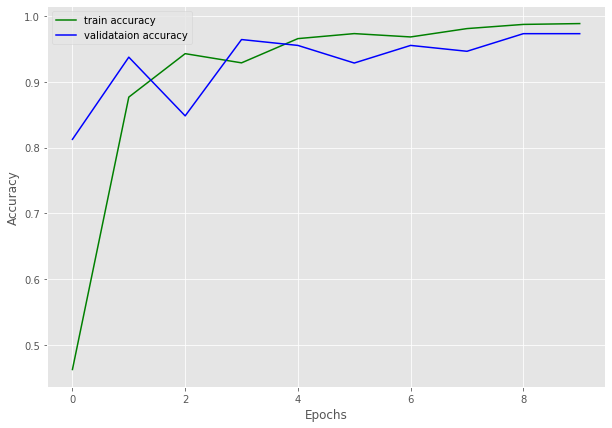

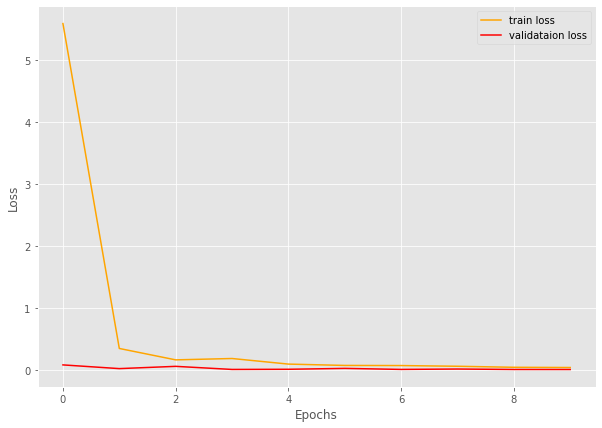

In [ ]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
# TODO: Implement your plots here, you can use matplotlib library to do so.
def save_plots_TL(train_acc, valid_acc, train_loss, valid_loss):
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('sample_data/accuracyTL.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('sample_data/lossTL.png')
# save the loss and accuracy plots
save_plots_TL(train_accuracies, val_accuracies, train_losses, val_losses)

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

Best model was saved at 10 epochs

Accuracy: 0.9513274336283186
Precision score is  0.9485994397759104
Recall score is  0.9485994397759104
F1 score is  0.9501165164396953


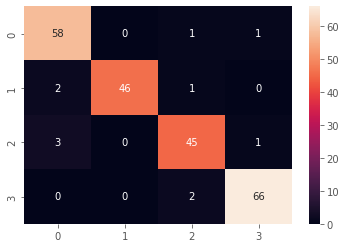

In [ ]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
is_gpu_available = torch.cuda.is_available()

# prepare the model
criterion = nn.CrossEntropyLoss()

model = build_model_TL(4)
model.cuda()

# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
# prepare test data loader
test_data_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

# bring best model back
best_model_cp = torch.load('sample_data/bestModelTL.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

# load the state of best model
model.load_state_dict(best_model_cp['model_state_dict'])

model.eval()
correct_preds = 0
total_preds = 0
all_preds = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for batch_data, batch_labels in test_data_loader:
        batch_labels = batch_labels.type(torch.LongTensor) 
        sample_channel = np.transpose(batch_data, (0,3,2,1)) 
        batch_outputs = model(sample_channel.to(torch.float32).cuda() )
        # Calculate the accuracy
        # Max returns: (max_values, max_indices)
        # We only need the indices to assess the predictions
        _, pred_labels = torch.max(batch_outputs, dim=1)
        total_preds += pred_labels.size(0)
        correct_preds += (pred_labels == batch_labels.cuda()).sum().item()
        all_preds = torch.cat((all_preds.cuda(), pred_labels.cuda()), dim=0)
        all_labels = torch.cat((all_labels.cuda(), batch_labels.cuda()), dim=0)

# Report accuracy      
print("Accuracy: {}".format(correct_preds / total_preds))

# Report confusion matrix
confusion_matrix = torch.zeros(4, 4, dtype=torch.int64)
for label_idx in range(len(all_labels)):
    predicted = all_preds[label_idx].int()
    real = all_labels[label_idx].int()
    confusion_matrix[real, predicted] += 1

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix.numpy(), annot=True, fmt="d")
fig.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Report macro precision
ps = precision_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("Precision score is ", ps)
# Report macro recall
rs = recall_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("Recall score is ", ps)
# Report f1 score
f1 = f1_score(all_preds.cpu().int(), all_labels.cpu().int(), average='macro')
print("F1 score is ", f1)

In [ ]:
#TODO:
#Pick your hyper parameters
#---------------------------------------------
max_epoch = 100
train_batch = 64
test_batch = 64
learning_rate = 5e-2
momentum = 0.5
weight_decay = 5e-04
#---------------------------------------------
# TODO: training loop + eval

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

The results highlight that using TL significantly improved the overall performance when compared to both FCNet and CNN. This high accuracy is essentially achieved by using a good pretrained model (ImageNet dataset is quite a remarkable dataset having more than 14 million images of various "objects" that may be used to comprehend similar cases ) and furthermore it decreases training time and generalization error.

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1